In [1]:
"""
Experiments to find a lower bound for local sensitivity
    From this and immediate sensitivity, we can find a lower bound on smoothness
"""

import time

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class MnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=(5,5))
        self.conv2 = nn.Conv2d(28, 32, kernel_size=(5,5))
        self.fc1 = nn.Linear(32*20*20, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = x.view(-1, 32*20*20)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        return torch.softmax(x,dim=1)

In [4]:
def inf_loader_generator(dataloader):
    '''
    Generates a function that infinitely samples a dataloader
    '''
    while True:
        for x, y in dataloader:
            yield x, y

In [5]:
def mnist_data_generator(split="train", batch_size=16, download=True, shuffle=False, drop_last=True, root='./data'):
    """
    Return infinite data generator and size of underlying dataset
    """
    if split == "test":
        dataset = datasets.MNIST(root='./data', train=False, download=download, transform=torchvision.transforms.ToTensor())
    else:
        dataset = datasets.MNIST(root='./data', train=True, download=download, transform=torchvision.transforms.ToTensor())
        if split == "train":
            dataset = Subset(dataset, list(range(0, 50000)))
        elif split == "validate" or split == "val":
            dataset = Subset(dataset, list(range(50000, 60000)))
        else:
            raise ValueError(f"Unrecognized split {split}. Must be one of ('train', 'val', test')")

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    generator = inf_loader_generator(dataloader)
    return generator, len(dataset)     

In [6]:
def model_accuracy(model, inf_gen, test_steps, device=DEVICE):
    correct = 0
    num_data = 0

    #grab a batch from the test loader
    for j in range(test_steps):
        examples, labels = next(inf_gen)
        outputs = model.forward(examples.to(device))

        #for each output in the batch, check if the label is correct
        for i, output in enumerate(outputs):
            num_data += 1

            max_i = np.argmax(output.detach().cpu().numpy())
            if max_i == labels[i]:
                correct += 1

    acc = float(correct)/num_data
    return acc

In [7]:
def compute_immediate_sensitivity(model, inp, loss) -> list:
    """Core. Computes immediate sensitivity"""

    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(
        loss,
        model.parameters(),
        retain_graph=True,
        create_graph=True,
        # allow_unused=True
    )

    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p=2)

    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    # (4) L2 norm of (3) - "immediate sensitivity"
    # sensitivity = [torch.norm(v, p=2).item() for v in sensitivity_vec]
    sensitivity = torch.norm(
        sensitivity_vec.view(sensitivity_vec.shape[0], -1), p=2, dim=1
    )
    
    return sensitivity

In [42]:
def compute_immediate_sensitivity_vec(model, criterion, x, y, device=DEVICE) -> list:
    """Core. Computes immediate sensitivity"""
    model.zero_grad()
    
    x = torch.autograd.Variable(torch.clone(x).to(device), requires_grad=True)
    y = y.to(device)

    outputs = model.forward(x)
    loss = criterion(outputs, y)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(
        loss,
        model.parameters(),
        retain_graph=True,
        create_graph=True,
        # allow_unused=True
    )

    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([w.view(-1) for w in first_order_grads]), p=2)

    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, x, retain_graph=True)[0]

    # (4) L2 norm of (3) - "immediate sensitivity"
    # sensitivity = [torch.norm(v, p=2).item() for v in sensitivity_vec]
    sensitivity = torch.norm(
        sensitivity_vec.view(sensitivity_vec.shape[0], -1), p=2, dim=1
    )    

    return sensitivity_vec

In [49]:
def compute_local_sensitivity_grad(model, criterion, x, y, grad_vec, device=DEVICE) -> list:
    """Core. Computes immediate sensitivity"""
    model.zero_grad()
    
    x = torch.autograd.Variable(torch.clone(x).to(device), requires_grad=True)
    y = y.to(device)

    outputs = model.forward(x)
    loss = criterion(outputs, y)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(
        loss,
        model.parameters(),
        retain_graph=True,
        create_graph=True,
        # allow_unused=True
    )

    # (2) L2 norm of the gradient from (1) minus the grad_vec term
    diff = torch.cat([w.view(-1) for w in first_order_grads]) - grad_vec
    grad_l2_norm = torch.norm(diff, p=2)

    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    x_sensitivity_vec = torch.autograd.grad(grad_l2_norm, x, retain_graph=True)[0]

    return x_sensitivity_vec

In [51]:
grad_vec = get_grad_vec(m.model, m.criterion, x_batch, y_batch)

In [52]:
grad_vec = get_grad_vec(m.model, m.criterion, x_batch, y_batch)
x1 = compute_local_sensitivity_grad(m.model, m.criterion, x_batch, y_batch, grad_vec)

In [54]:
x1.shape

torch.Size([16, 1, 28, 28])

In [38]:
class ModelTrainer:
    def __init__(self, device=DEVICE):
        self.device = device
        self.model = MnistClassifier()
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(),lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        
    def train(self, epochs=20, alpha=20, epsilon=1e6, batch_size=16):
        train_ds, train_size = mnist_data_generator(split="train", batch_size=batch_size)
        val_ds, val_size = mnist_data_generator(split="val", batch_size=batch_size)
        test_ds, test_size = mnist_data_generator(split="test", batch_size=batch_size)
        
        self.model_steps = 0
        self.train_losses = []
        self.val_accs = []
        self.times = []
        
        train_steps_per_epoch = train_size // batch_size
        current_epoch = 0
        while True:
            if self.model_steps >= epochs * train_steps_per_epoch:
                print("Finished Training")
                break
            if self.model_steps % train_steps_per_epoch == 0:
                self.batch_losses = []
                current_epoch += 1
                print(f"Start of Epoch {current_epoch}")
                start = time.time()

            x_batch, y_batch = (x.to(self.device) for x in next(train_ds))
            if alpha is None or epsilon is None:
                self._train_batch(x_batch, y_batch)
            else:
                self._train_batch_dp(x_batch, y_batch, alpha, epsilon / epochs)
            
            if self.model_steps % train_steps_per_epoch == 0:
                train_loss = np.mean(self.batch_losses)
                self.train_losses.append(train_loss)
                print(f"Average Train Loss: {train_loss}")
                
                self.val_accs.append(model_accuracy(self.model, val_ds, val_size // batch_size, device=DEVICE))
                print(f"Validation Accuracy: {self.val_accs[-1]}")
                end = time.time()
                elapsed = end - start
                print(f"Epoch time: {elapsed} seconds")
                print()
                self.times.append(elapsed)
        
        self.test_acc = model_accuracy(self.model, test_ds, test_size // batch_size, device=DEVICE)
        print(f"Final Test Accuracy: {self.test_acc}")
        
    def _train_batch(self, x_batch, y_batch):
        """
        Train on the next batch without differential privacy
        """
        self.optimizer.zero_grad()
        outputs = self.model.forward(x_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.batch_losses.append(loss.item())
        
        self.optimizer.step()
        self.model_steps += 1
        
    def _train_batch_dp(self, x_batch, y_batch, alpha, epsilon_iter):
        """
        Train on the next batch using differential privacy
        """
        self.optimizer.zero_grad()
        
        # Need grad on input for sensitivity; not sure if cloning is needed
        x_batch = torch.autograd.Variable(torch.clone(x_batch).to(self.device), requires_grad=True)
        
        # compute loss
        outputs = self.model.forward(x_batch)
        loss = self.criterion(outputs, y_batch)
        
        batch_sensitivities = compute_immediate_sensitivity(
            self.model, x_batch, loss
        )

        batch_sensitivity = torch.max(batch_sensitivities) / len(x_batch)
        
        loss.backward()
        # step 4. compute noise
        # this is the scale of the Gaussian noise to be added to the batch gradient
        sigma = torch.sqrt(
            (batch_sensitivity ** 2 * alpha) / (2 * epsilon_iter)
        )
        
        self.batch_losses.append(loss.item())
        
        # step 5. update gradients with computed sensitivities
        with torch.no_grad():
            for p in self.model.parameters():
                p.grad += sigma * torch.randn(1).to(self.device)
        
        # perform the a gradient step
        self.optimizer.step()
        self.model_steps += 1
    
    def get_sensitivity(self, x_batch, y_batch):
        self.optimizer.zero_grad()
        
        # Need grad on input for sensitivity; not sure if cloning is needed
        x_batch = torch.autograd.Variable(torch.clone(x_batch).to(self.device), requires_grad=True)
        y_batch = y_batch.to(self.device)
        
        # compute loss
        outputs = self.model.forward(x_batch)
        loss = self.criterion(outputs, y_batch)
        
        batch_sensitivities = compute_immediate_sensitivity(
            self.model, x_batch, loss
        )

        batch_sensitivity = torch.max(batch_sensitivities) / len(x_batch)
    
    def attack_batch(self, x_batch, y_batch):
        """
        Maximimize local sensitivity w.r.t. the input batch, modifying one sample
        """
        grad_loss = get_grad_loss(x_batch, y_batch)
        x_batch_adv = x_batch.copy()
        y_batch_adv = y_batch.copy()
        
        
    
        

In [10]:
m = ModelTrainer()
m.train(epochs=5)


Start of Epoch 1
Average Train Loss: 1.6474526336669921
Validation Accuracy: 0.9501
Epoch time: 28.852384090423584 seconds

Start of Epoch 2
Average Train Loss: 1.5150553749465943
Validation Accuracy: 0.9595
Epoch time: 28.487991094589233 seconds

Start of Epoch 3
Average Train Loss: 1.5132265546417236
Validation Accuracy: 0.9621
Epoch time: 28.448127269744873 seconds

Start of Epoch 4
Average Train Loss: 1.5028603552627564
Validation Accuracy: 0.9654
Epoch time: 28.452882766723633 seconds

Start of Epoch 5
Average Train Loss: 1.49680127910614
Validation Accuracy: 0.9702
Epoch time: 28.412206411361694 seconds

Finished Training
Final Test Accuracy: 0.9705


In [226]:
m2 = ModelTrainer()
m2.train(epochs=5, alpha=None, epsilon=None)

Start of Epoch 1
Average Train Loss: 1.726130439453125
Validation Accuracy: 0.8644
Epoch time: 15.434529066085815 seconds

Start of Epoch 2
Average Train Loss: 1.586967381477356
Validation Accuracy: 0.8879
Epoch time: 15.428438186645508 seconds

Start of Epoch 3
Average Train Loss: 1.5066126013183594
Validation Accuracy: 0.9788
Epoch time: 15.434360265731812 seconds

Start of Epoch 4
Average Train Loss: 1.4844073761749268
Validation Accuracy: 0.9779
Epoch time: 15.40767788887024 seconds

Start of Epoch 5
Average Train Loss: 1.4818200625228881
Validation Accuracy: 0.9775
Epoch time: 15.418771982192993 seconds

Finished Training
Final Test Accuracy: 0.979


In [13]:
print(m.model)

MnistClassifier(
  (conv1): Conv2d(1, 28, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(28, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)


In [15]:
batch_size = 16
train_ds, train_size = mnist_data_generator(split="train", batch_size=batch_size)
x_batch, y_batch = next(train_ds)
print(y_batch)

In [17]:
def get_grad_vec(model, criterion, x_batch, y_batch, device=DEVICE):
    """
    Get the gradient vector of the parameters
    """
    model.zero_grad()
    #x_grad = torch.autograd.Variable(torch.clone(x_batch).to(device), requires_grad=True)
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    outputs = model.forward(x_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    
    grad_vec = torch.cat([param.grad.view(-1) for param in model.parameters()])
    return grad_vec

In [18]:
def sensitivity_point(model, criterion, x_batch, y_batch, x_batch_adv, y_batch_adv, device=DEVICE):
    """
    Return the sensitivity for a specific point (local sensitivity without the maximization over the local region)
    """
    grad_vec = get_grad_vec(model, criterion, x_batch, y_batch, device=device)
    grad_vec_adv = get_grad_vec(model, criterion, x_batch_adv, y_batch_adv, device=device)
    return torch.norm(grad_vec - grad_vec_adv, p=2)

In [59]:
def sensitivity_point2(model, criterion, x_batch_adv, y_batch_adv, grad_vec, device=DEVICE):
    """
    Return the sensitivity for a specific point (local sensitivity without the maximization over the local region)
    """
    grad_vec_adv = get_grad_vec(model, criterion, x_batch_adv, y_batch_adv, device=device)
    return torch.norm(grad_vec - grad_vec_adv, p=2)

In [19]:
sensitivity_point(m.model, m.criterion, x_batch, y_batch, x_batch, y_batch)

tensor(1.7649e-10, device='cuda:0')

In [25]:
sensitivity_point(m.model, m.criterion, x_batch, y_batch, x_batch, y_batch)

tensor(2.5926e-10, device='cuda:0')

In [233]:
def attack_x(model, criterion, x_batch, y_batch, eps_step=0.25, steps=10, device=DEVICE, random_init=True, sign=False):
    max_sensitivities = []
    x_values = []
    grad_vec = get_grad_vec(model, criterion, x_batch, y_batch)
    y_batch_adv = torch.clone(y_batch).to(device)
    for i in range(len(x_batch)):
        print(f"\nindex {i}:")
        print("----------")
        max_sensitivity = 0
        x_value = x_batch[i].cpu().numpy()
        x_batch_adv = torch.clone(x_batch).to(device)
        if random_init:
            x_batch_adv[i] = torch.rand(x_batch[i].shape).to(device)
        
        sensitivity = sensitivity_point2(model, criterion, x_batch_adv, y_batch_adv, grad_vec).cpu().numpy()
        print(f"step = 0, local sensitivity = {sensitivity}")
        for j in range(steps):
            x_grad = compute_local_sensitivity_grad(model, criterion, x_batch_adv, y_batch_adv, grad_vec)
            x_grad = x_grad.to(device)
            if sign:
                x_grad = x_grad.sign()
            if x_grad[i].abs().mean() == 0.0:
                print("    0.0 Gradient. Restarting.")
                x_batch_adv[i] = torch.rand(x_batch[i].shape).to(device)
            #else:
            #    step = eps_step * x_grad[i] / torch.sqrt(torch.sum(x_grad[i] * x_grad[i]))
            #    x_batch_adv[i] = x_batch_adv[i] + step
            x_batch_adv[i] = x_batch_adv[i] + eps_step * x_grad[i]
            x_batch_adv = x_batch_adv.clamp(0.0, 1.0)
            sensitivity = sensitivity_point2(model, criterion, x_batch_adv, y_batch_adv, grad_vec).cpu().numpy()
            print(f"step = {j+1}, local sensitivity = {sensitivity}, grad.abs().mean() = {x_grad[i].abs().mean()}")
            if sensitivity > max_sensitivity:
                max_sensitivity = sensitivity
                x_value = x_batch_adv[i].cpu().numpy()
        max_sensitivities.append(max_sensitivity)
        x_values.append(x_value)
        print(f"step = final, local sensitivity = {max_sensitivity}")
    return np.hstack(max_sensitivities), np.stack(x_values)

In [276]:
def attack_train(model, criterion, x_batch, y_batch, device=DEVICE, steps=0):
    batch_size = 1
    max_sensitivities = []
    x_values = []
    indexes = []
    grad_vec = get_grad_vec(model, criterion, x_batch, y_batch)
    y_batch_adv = torch.clone(y_batch).to(device)
    for i in range(16): #len(x_batch)):
        ds, size = mnist_data_generator(split="train", batch_size=batch_size)
        print(f"\nindex {i}:")
        print("----------")
        max_sensitivity = 0
        x_value = x_batch[i].cpu().numpy()
        index = -1
        x_batch_adv = torch.clone(x_batch).to(device)
        sensitivity = sensitivity_point2(model, criterion, x_batch_adv, y_batch_adv, grad_vec).cpu().numpy()   
        for j in range(size):
            if j == steps:
                break
            x_j, y_j = next(ds)
            x_batch_adv[i] = x_j[0].to(device)
            y_batch_adv[i] = y_j[0].to(device)
            sensitivity = sensitivity_point2(model, criterion, x_batch_adv, y_batch_adv, grad_vec).cpu().numpy()
            #print(f"step = {j+1}, local sensitivity = {sensitivity}, grad.abs().mean() = {x_grad[i].abs().mean()}")
            if sensitivity > max_sensitivity:
                max_sensitivity = sensitivity
                x_value = x_batch_adv[i].cpu().numpy()
                index = j
        max_sensitivities.append(max_sensitivity)
        x_values.append(x_value)
        indexes.append(index)
        print(f"step = final, local sensitivity = {max_sensitivity}")
    return np.hstack(max_sensitivities), np.stack(x_values), np.array(indexes)

In [280]:
x_batch, y_batch = next(train_ds)

In [277]:
max_sensitivities, x_values, indexes = attack_train(m.model, m.criterion, x_batch, y_batch, steps=100)


index 0:
----------
step = final, local sensitivity = 0.2299298644065857

index 1:
----------
step = final, local sensitivity = 0.22999446094036102

index 2:
----------
step = final, local sensitivity = 0.2299945056438446

index 3:
----------
step = final, local sensitivity = 0.22999455034732819

index 4:
----------
step = final, local sensitivity = 0.22999724745750427

index 5:
----------
step = final, local sensitivity = 0.22999775409698486

index 6:
----------
step = final, local sensitivity = 0.22999775409698486

index 7:
----------
step = final, local sensitivity = 0.22999775409698486

index 8:
----------
step = final, local sensitivity = 0.22999776899814606

index 9:
----------
step = final, local sensitivity = 0.22999775409698486

index 10:
----------
step = final, local sensitivity = 0.22999775409698486

index 11:
----------
step = final, local sensitivity = 0.22999782860279083

index 12:
----------
step = final, local sensitivity = 0.22999785840511322

index 13:
----------
st

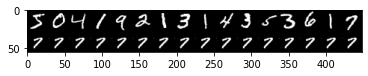

In [279]:
import matplotlib.pyplot as plt
x_values.min(), x_values.max()
X = x_values.reshape((16, 28, 28))
X = np.hstack(X)
Xorig = x_batch.cpu().numpy()
Xorig = Xorig.reshape((16, 28, 28))
Xorig = np.hstack(Xorig)

Xcomb = np.vstack([Xorig, X])

plt.gray()
plt.imshow(Xcomb)


index 0:
----------
step = 0, local sensitivity = 0.059980735182762146
step = 1, local sensitivity = 0.01685219444334507, grad.abs().mean() = 1.0
step = 2, local sensitivity = 0.016873888671398163, grad.abs().mean() = 1.0
step = 3, local sensitivity = 0.01788613386452198, grad.abs().mean() = 1.0
step = 4, local sensitivity = 0.016873888671398163, grad.abs().mean() = 1.0
step = 5, local sensitivity = 0.016873881220817566, grad.abs().mean() = 1.0
step = 6, local sensitivity = 0.016873888671398163, grad.abs().mean() = 1.0
step = 7, local sensitivity = 0.016585232689976692, grad.abs().mean() = 1.0
step = 8, local sensitivity = 0.02120441198348999, grad.abs().mean() = 1.0
step = 9, local sensitivity = 0.018102996051311493, grad.abs().mean() = 1.0
    0.0 Gradient. Restarting.
step = 10, local sensitivity = 0.04746251180768013, grad.abs().mean() = 0.0
step = 11, local sensitivity = 0.016867877915501595, grad.abs().mean() = 1.0
step = 12, local sensitivity = 0.014466434717178345, grad.abs().

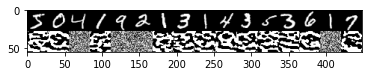

In [239]:
max_sensitivities, x_values = attack_x(m.model, m.criterion, x_batch, y_batch, steps=20, eps_step=50, random_init=True, sign=True)
import matplotlib.pyplot as plt
x_values.min(), x_values.max()
X = x_values.reshape((16, 28, 28))
X = np.hstack(X)
Xorig = x_batch.cpu().numpy()
Xorig = Xorig.reshape((16, 28, 28))
Xorig = np.hstack(Xorig)

Xcomb = np.vstack([Xorig, X])

plt.gray()
plt.imshow(Xcomb)


index 0:
----------
step = 0, local sensitivity = 0.004952771123498678
step = 1, local sensitivity = 0.13387128710746765, grad.abs().mean() = 1.0
step = 2, local sensitivity = 3.9505471810530324e-11, grad.abs().mean() = 1.0
step = 3, local sensitivity = 2.353284754563756e-11, grad.abs().mean() = 1.0
    0.0 Gradient. Restarting.
step = 4, local sensitivity = 0.05211900547146797, grad.abs().mean() = 0.0
step = 5, local sensitivity = 0.06549323350191116, grad.abs().mean() = 1.0
step = 6, local sensitivity = 2.5978285494998588e-11, grad.abs().mean() = 1.0
step = 7, local sensitivity = 7.944114489226006e-15, grad.abs().mean() = 1.0
step = 8, local sensitivity = 0.012541144154965878, grad.abs().mean() = 1.0
step = 9, local sensitivity = 1.2658615560212638e-06, grad.abs().mean() = 1.0
step = 10, local sensitivity = 6.19036472926382e-06, grad.abs().mean() = 1.0
step = 11, local sensitivity = 2.847716637152664e-14, grad.abs().mean() = 1.0
step = 12, local sensitivity = 2.3533900522787476e-11,

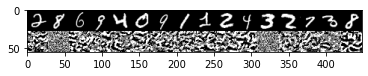

In [281]:
max_sensitivities, x_values = attack_x(m2.model, m2.criterion, x_batch, y_batch, steps=20, eps_step=0.5, random_init=True, sign=True)
x_values.min(), x_values.max()
X = x_values.reshape((16, 28, 28))
X = np.hstack(X)
Xorig = x_batch.cpu().numpy()
Xorig = Xorig.reshape((16, 28, 28))
Xorig = np.hstack(Xorig)

Xcomb = np.vstack([Xorig, X])

plt.gray()
plt.imshow(Xcomb)

In [197]:
(0.9375) * 28*28

735.0

In [83]:
def attack_y(model, criterion, x_batch, y_batch, n=10, device=DEVICE):
    """
    Determine the worst case sensitivity by switching the value of y
    """
    max_sensitivities = []
    y_values = []
    grad_vec = get_grad_vec(model, criterion, x_batch, y_batch, device=device)
    for i in range(len(x_batch)):
        max_sensitivity = 0
        y_value = y_batch[i].cpu().numpy()
        for j in range(1, n):
            y_batch_adv = torch.clone(y_batch)
            y_batch_adv[i] = (y_batch[i] + j) % n
            grad_vec_adv = get_grad_vec(model, criterion, x_batch, y_batch_adv, device=DEVICE)
            sensitivity = torch.norm(grad_vec - grad_vec_adv, p=2).cpu().numpy()
            if sensitivity > max_sensitivity:
                max_sensitivity = sensitivity
                y_value = y_batch_adv[i].cpu().numpy()
        max_sensitivities.append(max_sensitivity)
        y_values.append(y_value)
    return np.hstack(max_sensitivities), np.hstack(y_values)

In [282]:
max_sensitivities, y_values = attack_y(m.model, m.criterion, x_batch, y_batch, n=10)

In [283]:
max_sensitivities

array([5.8087397e-09, 4.5583787e-05, 1.7107064e-06, 1.8623197e-08,
       5.6080234e-09, 5.7029808e-09, 1.1994807e-03, 1.3006899e-05,
       5.3975262e-02, 5.8730079e-09, 4.9425522e-05, 5.2547442e-09,
       7.3737468e-08, 5.2461380e-01, 9.0845473e-09, 6.9930316e-08],
      dtype=float32)

In [35]:
y_values - y_batch.cpu().numpy()

array([-2,  2, -3,  8, -5,  4,  5, -1,  5,  3,  3, -2,  3, -3,  7,  2])

In [47]:
immediate_sensitivities = compute_immediate_sensitivity_full(m.model, m.criterion, x_batch, y_batch).cpu().numpy()

In [48]:
for i, j in zip(max_sensitivities, immediate_sensitivities):
    local_smoothness_lower_bound = i / j
    print(i, j, local_smoothness_lower_bound)

0.039514653 0.49594343 0.07967573
2.945177e-10 2.7165287e-13 1084.1692
6.915192e-07 2.438257e-07 2.836121
5.7981288e-06 2.3888936e-06 2.427119
2.1054919e-05 5.6466006e-06 3.728778
2.9764743e-10 5.353799e-16 555955.56
3.0935168e-10 7.526046e-12 41.104145
3.1393993e-10 3.074149e-11 10.2122555
7.869117e-07 3.1886884e-07 2.4678226
2.8855662e-10 2.0095353e-12 143.5937
3.0389588e-10 2.1031386e-10 1.4449636
1.1512084e-06 6.829997e-06 0.16855182
2.9793532e-10 7.3394934e-16 405934.44
2.8294303e-10 4.354814e-13 649.72473
4.7116228e-05 6.768869e-07 69.60724
2.2214237e-05 3.912854e-06 5.6772466


In [55]:
print(v.shape)

torch.Size([228146])


In [56]:
v.grad

/home/david.slater/.conda/envs/csl/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  """Entry point for launching an IPython kernel.


In [57]:
w = torch.cat([param.view(-1) for param in m.model.parameters()])

In [58]:
w.shape

torch.Size([228146])

In [73]:
torch.norm(w, p=2).cpu().numpy()

array(0.12015969, dtype=float32)

In [104]:
sensitivity_point(m.model, m.criterion, x_batch, y_batch, x_batch, y_batch)

RuntimeError: CUDA error: device-side assert triggered

In [83]:
(x_batch + 1).max()

tensor(2.)

In [96]:
(y_batch+1) % 10

tensor([6, 1, 5, 2, 0, 3, 2, 4, 2, 5, 4, 6, 4, 7, 2, 8])

In [99]:
y_batch_2 = (y_batch+1) % 10

In [39]:
m.get_sensitivity(x_batch, y_batch.to(DEVICE))

In [86]:
def get_local_sensitivity_grad_vec(model, criterion, x_batch, y_batch, grad_vec, device=DEVICE):
    """
    Get the gradient of the objective of the maximization w.r.t. the input x_batch
    
    || D_W(x) - grad_vec ||2
    """
    model.zero_grad()
    #x_grad = torch.autograd.Variable(torch.clone(x_batch).to(device), requires_grad=True)
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    outputs = model.forward(x_grad)
    loss = criterion(outputs, y_batch)
    loss.backward()
    
    grad_vec = torch.cat([param.grad.view(-1) for param in model.parameters()])
    return grad_vec